# Seattle Collisions - Model Training

This notebook covers model training for FB Prophet also does evaluation because the evaluation notebook is getting crowded with the mapping code.

In [55]:
from fbprophet import Prophet
from fbprophet.serialize import model_to_json, model_from_json
from fbprophet.plot import plot_cross_validation_metric 
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation

from sklearn.neighbors import BallTree
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import json
from math import sqrt
import pandas as pd
import types
import itertools
import numpy as np
from datetime import datetime, timedelta, timezone 
import time

import os
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
%matplotlib inline

In [56]:
df = pd.read_csv('Seattle_Collisions_Final.csv', low_memory = False, parse_dates=True, index_col=0)
df['INCDTTM'] = pd.to_datetime(df['INCDTTM'])
df_weather = pd.read_csv('Seattle_Weather_Daily.csv', low_memory = False, parse_dates=True, index_col=0)
#df_weather.info()

In [57]:
def get_day_max_temperature(dfw, target_date):
    return dfw[(dfw.DATE == target_date)]['TEMPERATURE'].max()

def get_day_min_temperature(dfw, target_date):
    return dfw[(dfw.DATE == target_date)]['TEMPERATURE'].min()

def get_day_total_precipitation(dfw, target_date):
    return dfw[(dfw.DATE == target_date)]['PRECIPITATION'].sum()

def get_day_solar_azimuth(dfw, target_date):
    return dfw[(dfw.DATE == target_date)]['SOLARAZIMUTH'].max()

In [58]:
dft = df[(df.INCDTTM > '2014-12-31') & (df.INCDTTM < '2020-01-01') &\
         (df.HITPARKEDCAR == 0) & (df.PRECIPITATION >= 0) & (df.WEEKDAY.isin([0,1,2,3,4,5,6]))]
print(len(dft), len(dft)/(dft.INCDTTM.max() - dft.INCDTTM.min()).days)

47279 25.8921139101862


In [59]:
dft = dft.INCDTTM.value_counts().resample('D').sum().to_frame().reset_index()
dft.rename({'index':'ds', 'INCDTTM':'y'}, axis=1, inplace=True)
dft['rain'] = dft.apply(lambda x: get_day_total_precipitation(df_weather, x.ds.strftime('%Y-%m-%d')), axis=1)
dft['temp'] = dft.apply(lambda x: get_day_min_temperature(df_weather, x.ds.strftime('%Y-%m-%d')), axis=1)
#dft['solar_azimuth'] = dft.apply(lambda x: get_day_solar_azimuth(df_weather, x.ds.strftime('%Y-%m-%d')), axis=1)
#dft.y.plot(figsize=(18,3))
dft.head()

,ds,y,rain,temp
0,2014-12-31,32,0.00,32.1
1,2015-01-01,32,0.00,26.9
2,2015-01-02,20,0.03,32.1
3,2015-01-03,21,0.00,34.1
4,2015-01-04,18,0.21,41.1


In [60]:
m = Prophet(daily_seasonality=True, weekly_seasonality=True, changepoint_prior_scale=0.5,\
            seasonality_prior_scale=0.01, growth='linear', seasonality_mode='multiplicative') 
m.add_regressor('rain', mode='multiplicative')
m.add_regressor('temp', mode='additive')
#m.add_regressor('solar_azimuth', mode='multiplicative')
m.fit(dft)
future = m.make_future_dataframe(periods=10,freq='D',include_history=True)

In [62]:
future['rain'] = future.apply(lambda x: get_day_total_precipitation(df_weather, x.ds.strftime('%Y-%m-%d')), axis=1)
future['temp'] = future.apply(lambda x: get_day_min_temperature(df_weather, x.ds.strftime('%Y-%m-%d')), axis=1)
#future['solar_azimuth'] = future.apply(lambda x: get_day_solar_azimuth(df_weather, x.ds.strftime('%Y-%m-%d')), axis=1)
future.head(), future.tail()

(          ds  rain  temp
 0 2014-12-31  0.00  32.1
 1 2015-01-01  0.00  26.9
 2 2015-01-02  0.03  32.1
 3 2015-01-03  0.00  34.1
 4 2015-01-04  0.21  41.1,
              ds  rain  temp
 1832 2020-01-06  0.03  42.0
 1833 2020-01-07  0.10  48.7
 1834 2020-01-08  0.00  34.2
 1835 2020-01-09  0.00  33.0
 1836 2020-01-10  0.15  34.9)

In [63]:
forecast = m.predict(future)
dft_results = dft.merge(forecast, how='outer', left_on='ds', right_on='ds')
dft_results[['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'additive_terms','multiplicative_terms']].tail(10)

,ds,y,yhat,yhat_lower,yhat_upper,trend,additive_terms,multiplicative_terms
1827,2020-01-01,NaN,20.344165,12.248841,27.845720,23.441057,-0.225377,-0.122499
1828,2020-01-02,NaN,20.970758,12.885477,29.390808,23.438267,-0.424015,-0.087186
1829,2020-01-03,NaN,22.095910,13.741733,30.056238,23.435478,-0.046603,-0.055171
1830,2020-01-04,NaN,18.989783,10.282814,26.667040,23.432689,-0.404151,-0.172356
1831,2020-01-05,NaN,17.362737,9.341067,25.342914,23.429900,-0.476985,-0.238592
1832,2020-01-06,NaN,19.454750,11.676066,27.171145,23.427111,-0.424015,-0.151463
1833,2020-01-07,NaN,22.214591,14.755085,30.245521,23.424322,0.019610,-0.052481
1834,2020-01-08,NaN,20.375855,12.418328,28.346359,23.421533,-0.940474,-0.089883
1835,2020-01-09,NaN,21.232480,13.299119,29.464720,23.418743,-1.019929,-0.049803
1836,2020-01-10,NaN,23.179864,15.037989,31.222413,23.415954,-0.894125,0.028102


MAE: 4.947
RMSE: 6.325


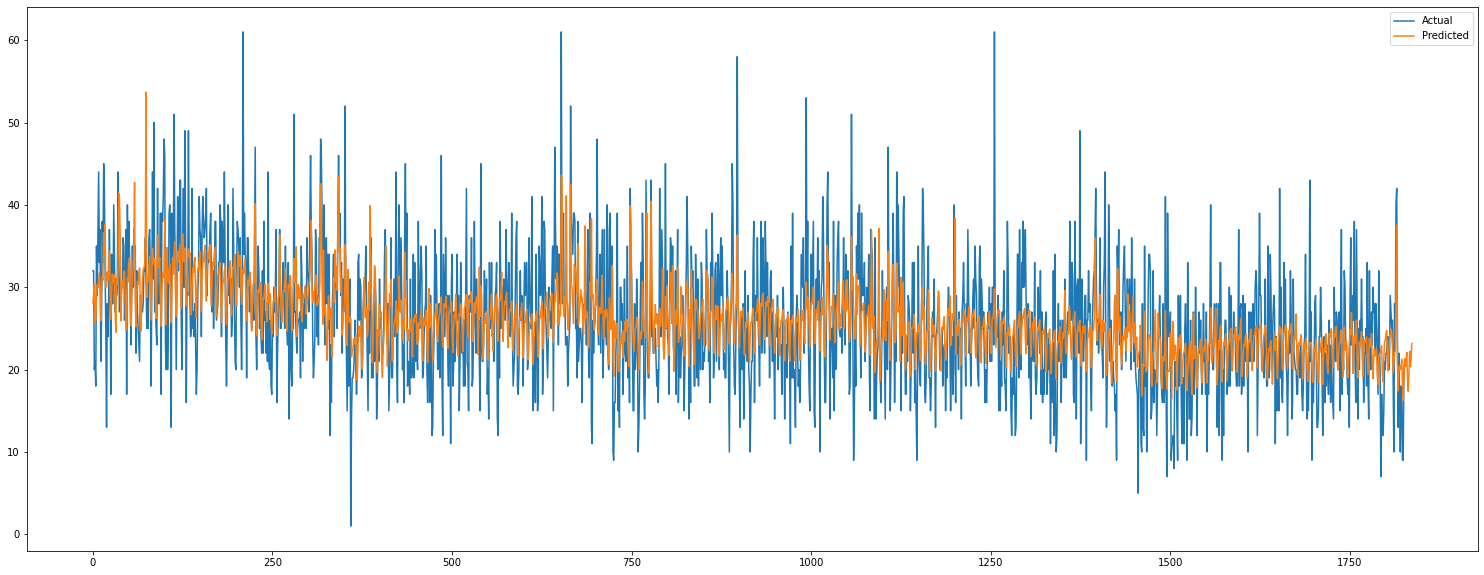

In [64]:
y_true = dft_results['y'].values
y_hat = dft_results['yhat'].values
mae = mean_absolute_error(y_true[:-10], y_hat[:-10])
print('MAE: %.3f' % mae)
rsme = sqrt(mean_squared_error(y_true[:-10], y_hat[:-10]))
print('RMSE: %.3f' % rsme)

fig, ax = plt.subplots(figsize=(26,10))
plt.plot(y_true, label='Actual')
plt.plot(y_hat, label='Predicted')
plt.legend()

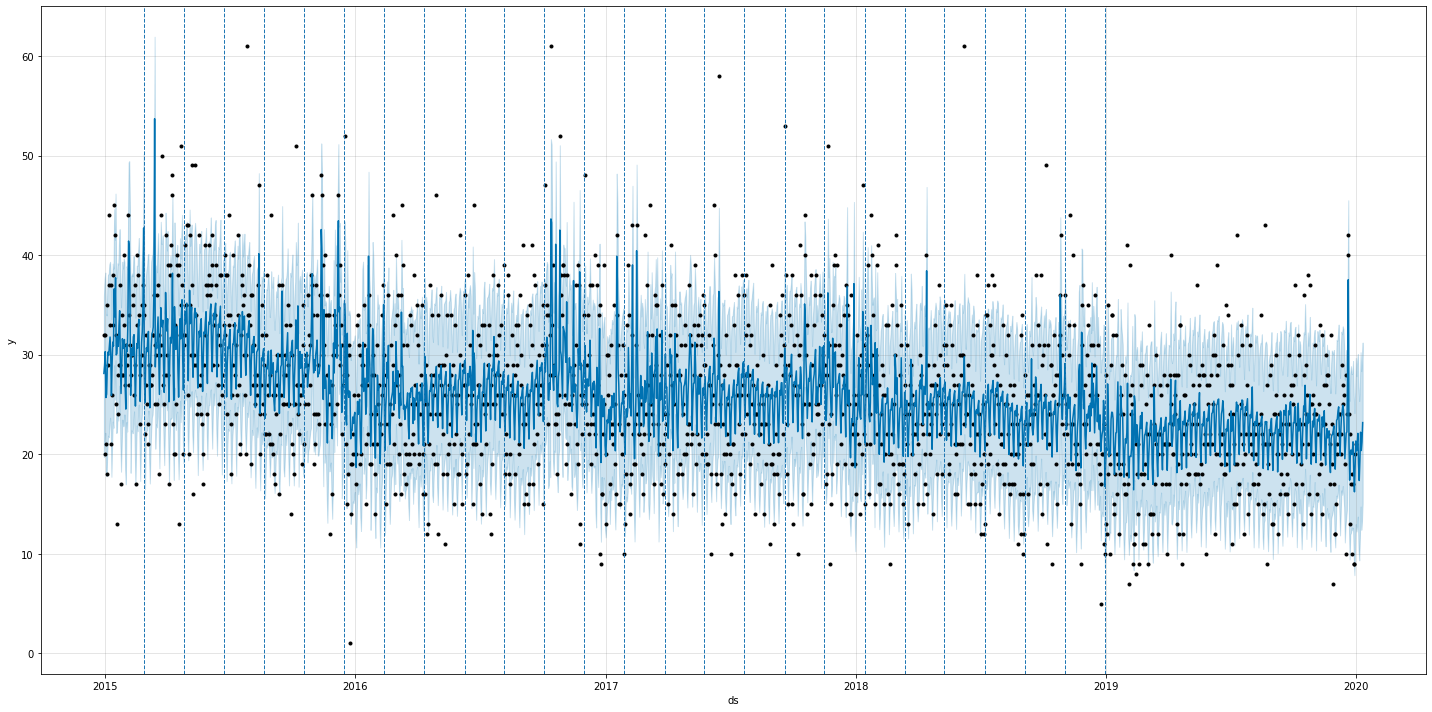

In [65]:
f = m.plot(forecast, figsize=(20,10))
for changepoint in m.changepoints:
    plt.axvline(changepoint,ls='--', lw=1)

/opt/conda/lib/python3.7/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/opt/conda/lib/python3.7/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/opt/conda/lib/python3.7/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/opt/conda/lib/python3.7/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


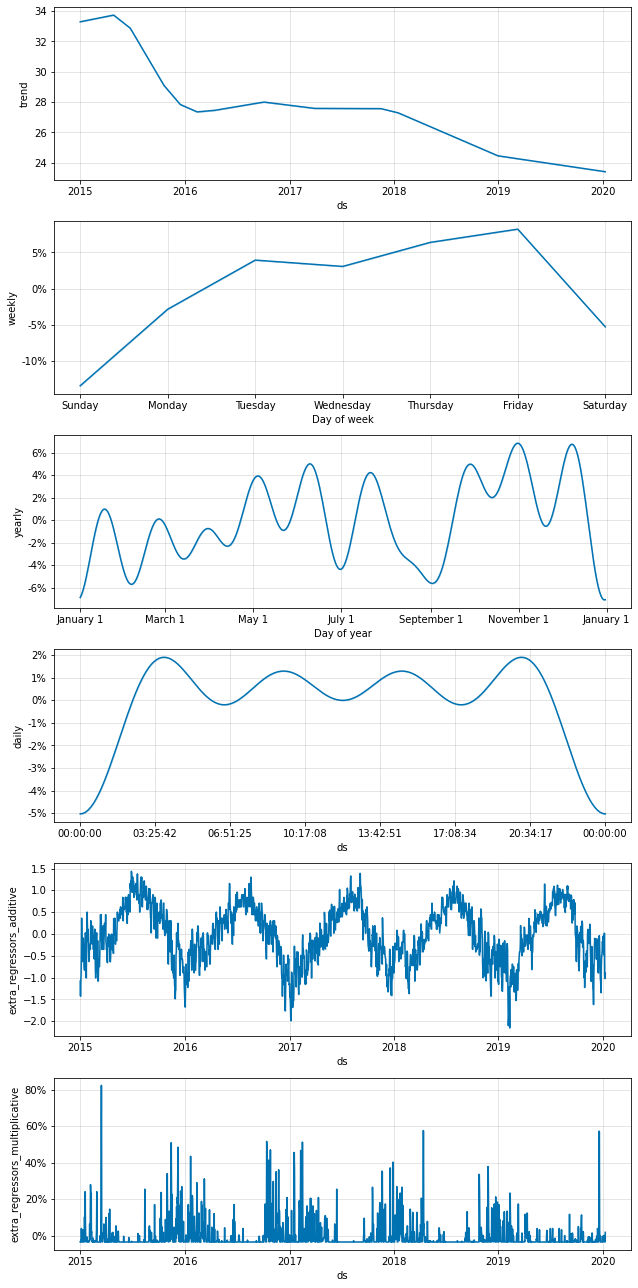

In [66]:
f = m.plot_components(forecast)

In [67]:
rs = np.random.RandomState(0)
corr = df.corr()
cm = sns.light_palette("green", as_cmap=True)
corr.style.background_gradient(cmap=cm).set_precision(2)

,X,Y,ADDRTYPE,SEVERITYCODE,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,SDOT_COLCODE,INATTENTIONIND,UNDERINFL,PEDROWNOTGRNT,SPEEDING,HITPARKEDCAR,YEAR,MONTH,WEEKDAY,HOUR,TEMPERATURE,WINDCHILL,PRECIPITATION,SNOWDEPTH,VISIBILITY,CLOUDCOVER,MOONPHASE,PEAKOROFFPEAK,solar_azimuth,solar_azimuth_round,solar_elevation
X,1.00,-0.17,0.01,0.01,0.01,0.01,0.01,-0.00,-0.01,0.01,-0.02,-0.03,0.01,-0.01,0.00,0.01,0.00,-0.01,0.01,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.02
Y,-0.17,1.00,0.03,0.02,-0.04,-0.01,0.01,0.03,0.02,-0.02,0.01,-0.01,0.02,-0.03,-0.01,-0.03,0.01,-0.01,0.02,0.01,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.02,0.03,0.03,0.00
ADDRTYPE,0.01,0.03,1.00,0.20,-0.48,0.06,0.14,0.08,-0.08,-0.03,-0.08,-0.04,0.16,-0.05,0.01,0.04,-0.00,-0.01,0.04,-0.00,0.02,0.02,-0.00,-0.01,0.00,-0.01,0.04,-0.00,-0.00,0.03
SEVERITYCODE,0.01,0.02,0.20,1.00,-0.13,0.13,0.25,0.22,-0.06,0.19,0.05,0.04,0.21,0.04,0.01,0.02,0.00,-0.02,0.03,0.04,-0.02,0.01,0.00,0.00,0.00,-0.00,0.04,-0.00,-0.00,0.04
COLLISIONTYPE,0.01,-0.04,-0.48,-0.13,1.00,0.01,0.10,-0.21,0.10,0.00,0.12,0.01,-0.02,-0.00,-0.00,-0.02,0.01,-0.02,0.00,0.01,-0.01,-0.01,0.00,0.01,-0.01,0.00,0.01,0.00,0.00,0.01
PERSONCOUNT,0.01,-0.01,0.06,0.13,0.01,1.00,-0.02,-0.04,0.38,-0.14,0.08,0.02,-0.03,0.00,-0.03,-0.06,-0.00,0.06,0.04,0.01,-0.00,0.00,-0.01,0.00,-0.02,-0.01,0.03,0.03,0.03,0.02
PEDCOUNT,0.01,0.01,0.14,0.25,0.10,-0.02,1.00,-0.02,-0.27,0.27,-0.00,0.02,0.50,-0.03,0.00,0.02,0.01,-0.02,0.03,-0.02,0.02,0.02,-0.00,-0.02,0.00,0.00,0.02,-0.00,-0.00,0.00
PEDCYLCOUNT,-0.00,0.03,0.08,0.22,-0.21,-0.04,-0.02,1.00,-0.26,0.39,0.00,-0.02,0.32,-0.02,0.01,0.03,0.01,-0.03,0.03,0.05,-0.03,-0.02,-0.00,0.02,-0.02,0.00,0.04,-0.01,-0.01,0.05
VEHCOUNT,-0.01,0.02,-0.08,-0.06,0.10,0.38,-0.27,-0.26,1.00,-0.38,0.08,0.01,-0.23,-0.02,-0.02,-0.11,0.01,0.01,0.13,0.04,-0.01,-0.00,-0.00,0.01,0.00,-0.00,0.11,-0.07,-0.07,0.13
SDOT_COLCODE,0.01,-0.02,-0.03,0.19,0.00,-0.14,0.27,0.39,-0.38,1.00,0.03,0.11,0.25,0.14,-0.01,-0.04,-0.00,0.01,-0.03,-0.02,0.00,0.01,0.00,-0.01,-0.00,0.00,-0.05,-0.03,-0.03,-0.05


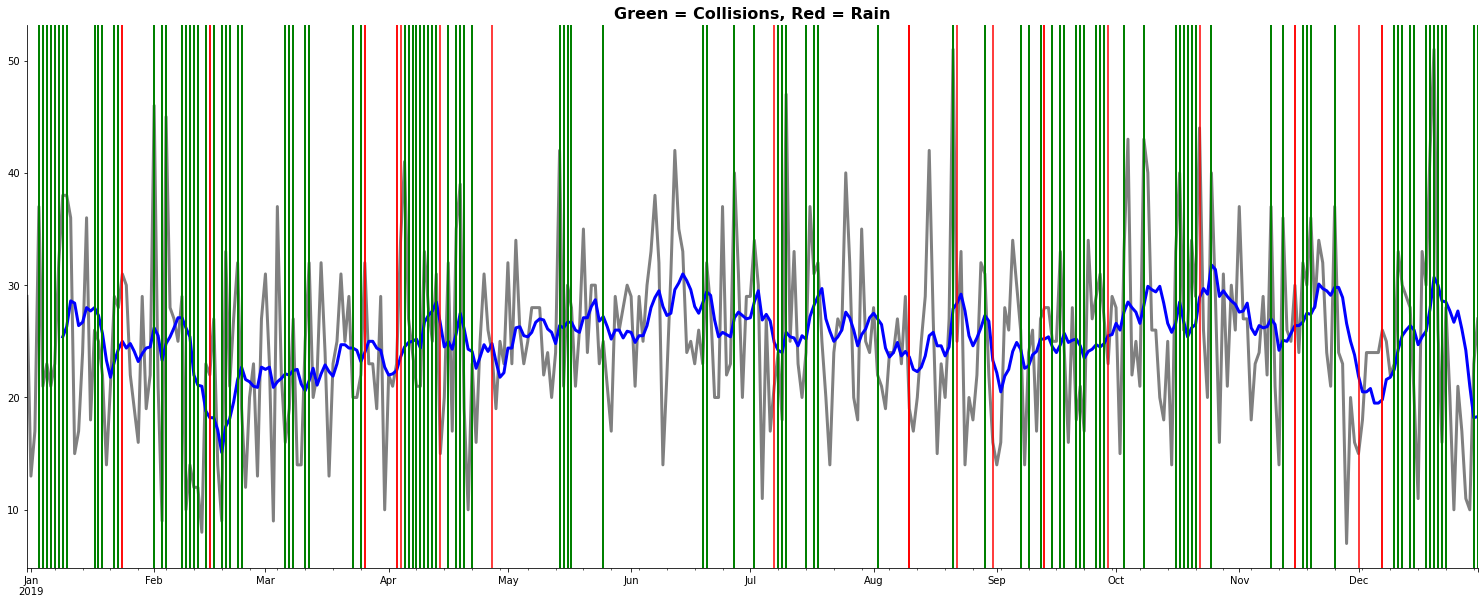

In [68]:
wdf = df_weather[(df_weather.TIMESTAMP > '2018-12-31') & (df_weather.TIMESTAMP < '2020-01-01')]
tdf = df[(df.INCDTTM > '2018-12-31') & (df.INCDTTM < '2020-01-01')]

xposition = wdf['TIMESTAMP'][(wdf.PRECIPITATION > 0)]
xposition2 = tdf['INCDTTM'][(tdf.PRECIPITATION > 0)]

fig, ax = plt.subplots(figsize=(26,10))
tdf.set_index('INCDTTM').resample('d').size().plot(label='Totals per Day', color='grey', ax=ax, linewidth=3)
tdf.set_index('INCDTTM').resample('d').size().rolling(window=10).mean()\
                    .plot(color='blue', linewidth=3, label='10-Month Moving Average', ax=ax)
for xc in xposition:
    ax.axvline(x=xc, color='red', linestyle='-')
for xc in xposition2:
    ax.axvline(x=xc, color='green', linestyle='-', linewidth=2)
ax.set_title('Green = Collisions, Red = Rain', fontweight = 'bold', fontsize=16)
ax.set_xlabel('')
ax.set_ylabel('')
#ax.legend(frameon=False, bbox_to_anchor=(1, 1))
sns.despine(ax=ax, top=True, bottom=False, left=False, right=True)

In [ ]:
#with open('seattle_collision_model.json', 'w') as fout:
#    json.dump(model_to_json(m), fout)  # Save model

Prophet has many tools built-in.  I did not extensively use these yet due to time constraints, a todo to revisit this and improve on what's here.

In [13]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

#https://facebook.github.io/prophet/docs/diagnostics.html
#Here we do cross-validation to assess prediction performance on a horizon of 365 days, starting with 730 days of training data in the first 
#cutoff and then making predictions every 180 days. On this 8 year time series, this corresponds to 11 total forecasts.
#df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(dft)  # Fit model with given params
    df_cv = cross_validation(m, initial='1460 days', period='10 days', horizon='365 days')  #cutoffs=cutoffs, , parallel="processes"
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)
best_params = all_params[np.argmin(rmses)]
print(best_params)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-12-31 00:00:00 and 2018-12-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-12-31 00:00:00 and 2018-12-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-12-31 00:00:00 and 2018-12-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-12-31 00:00:00 and 2018-12-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-12-31 00:00:00 and 2018-12-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-12-31 00:00:00 and 2018-12-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-12-31 00:00:00 and 2018-12-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-12-31 00:00:00 and 2018-12-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-12-31 00:00:00 and 2018-12-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-12-31 00:00:00 and 2018-12-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-12-31 00:00:00 and 2018-12-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-12-31 00:00:00 and 2018-12-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-12-31 00:00:00 and 2018-12-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-12-31 00:00:00 and 2018-12-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-12-31 00:00:00 and 2018-12-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-12-31 00:00:00 and 2018-12-31 00:00:00



    changepoint_prior_scale  seasonality_prior_scale      rmse
0                     0.001                     0.01  6.160605
1                     0.001                     0.10  6.224084
2                     0.001                     1.00  6.224082
3                     0.001                    10.00  6.224109
4                     0.010                     0.01  6.076726
5                     0.010                     0.10  6.086581
6                     0.010                     1.00  6.097906
7                     0.010                    10.00  6.086780
8                     0.100                     0.01  6.079692
9                     0.100                     0.10  6.086483
10                    0.100                     1.00  6.084634
11                    0.100                    10.00  6.084181
12                    0.500                     0.01  6.076642
13                    0.500                     0.10  6.102769
14                    0.500                     1.00  